**AI & DL**

# Лабораторная работа №7

Выполнил: Инютин М. А.

Группа: М8О-407Б-19

## Подключение необходимых библиотек

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import division, print_function

import copy
import os
import pathlib
import time
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import onnx
import onnxruntime
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.onnx
import torch.optim as optim
import torchvision
from PIL import Image
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms

cudnn.benchmark = True
plt.ion()

## Гиперпараметры модели

In [2]:
MY_EPOCHS = 80
MY_MOMENTUM = 0.9
MY_LABEL_SMOOTHING = 0.1
MY_LR = 0.01
MY_WEIGHT_DECAY = 0.0001

## Загрузка [датасета](https://www.kaggle.com/datasets/jessicali9530/caltech256)

### Загрузка изображений из файла

Разбиение задано в файле, поэтому загружаю датасет с помощью вспомогательного [класса](https://www.learnpytorch.io/04_pytorch_custom_datasets/#52-create-a-custom-dataset-to-replicate-imagefolder)

In [3]:
# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize with a targ_file and transform (optional) parameter
    def __init__(self, targ_file: str, prefix=None, transform=None) -> None:
        # 3. Create class attributes
        # Get all image paths
        self.classes, self.paths = list(), list()
        with open(targ_file, "r") as f:
            for row in f:
                path, class_id, _ = row.split()
                class_str = path.split("/")[1]
                path = prefix + path
                self.paths.append(pathlib.Path(path))
                if class_str not in self.classes:
                    self.classes.append(class_str)
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.class_to_idx = dict()
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path).convert("RGB")

    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name = self.paths[
            index
        ].parent.name  # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]
        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx  # return data, label (X, y)
        else:
            return img, class_idx  # return data, label (X, y)

### Аугментация

Для валидации изменяю размер изображения, а для обучения применяю [аугментацию](https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py)

In [4]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
            transforms.RandAugment(),
            transforms.TrivialAugmentWide(),
            transforms.AugMix(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

### Загрузка изображений

In [5]:
image_datasets = {
    x: ImageFolderCustom(
        targ_file=x + "_lst.txt",
        prefix="../data/",
        transform=data_transforms[x],
    )
    for x in ["train", "val"]
}


def collate_fn(batch):
    return (torch.stack([x[0] for x in batch]), torch.tensor([x[1] for x in batch]))


dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x],
        batch_size=4,
        shuffle=True,
        num_workers=8,
        collate_fn=collate_fn,
    )
    for x in ["train", "val"]
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
class_names = image_datasets["train"].classes

Выбор `device` для обучения

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Вспомогательные функции

### Визуализация изображений, пример входных данных

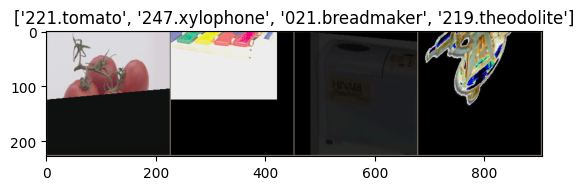

In [7]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Берём первый батч данных
inputs, classes = next(iter(dataloaders["train"]))

# Создание сетки
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Веса классов

Классы в наборе данных несбалансированы, поэтому для них нужно посчитать веса

In [8]:
cnt = [0 for _ in range(len(class_names))]
for _, y in image_datasets["train"]:
    cnt[y] += 1

class_weights = torch.Tensor([dataset_sizes["train"] / elem for elem in cnt]).to(device)
class_weights = torch.nn.functional.normalize(class_weights, dim=0)

### Функция для тренировки модель

На каждой эпохе прогоняем на всех данных, сохраняем модель, чтобы потом выбрать наилучшую версию

In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # На каждой эпохе вычисляем метрики для обучающей и тестовой выборки
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs - 1}")
        print("-" * 10)

        # Изменяем режим модели в зависимости от того, тренируем или валидируем
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Проходим по всем батчам данных
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Если обучаем, то распространяем ошибку на веса
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # Считаем loss
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Копируем модель для выбора лучшей
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # Печатаем суммарное время и счёт лучшей модели
    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:4f}")

    # Загружаем лучшую модель
    model.load_state_dict(best_model_wts)
    return model

### Визуализация результатов обучения

Отображаем несколько изображений и предсказанное значение

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    # Выключаем вычисление градиента
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(f"predicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### ONNX

Функция для экспортирования модели в формат `.onnx`

In [11]:
def save_to_ONNX(model, name):
    dummy_input = torch.randn(10, 3, 224, 224, device=device)
    model.eval()
    torch.onnx.export(
        model,
        dummy_input,
        name + ".onnx",
        export_params=True,
        do_constant_folding=True,
        input_names=[name + "Input"],
        output_names=[name + "Output"],
        dynamic_axes={
            name + "Input": {0: "batch_size"},
            name + "Output": {0: "batch_size"},
        },
    )

Функция импортирует модель из формата `.onnx` и прогоняет её на данных, вычисляет точность

In [12]:
def check_ONNX(name):
    # Load the ONNX model
    model = onnx.load(name + ".onnx")

    # Check that the model is well formed
    onnx.checker.check_model(model)

    ort_session = onnxruntime.InferenceSession(name + ".onnx")
    running_corrects = 0
    for inputs, labels in dataloaders["val"]:
        # compute ONNX Runtime output prediction
        ort_outs = ort_session.run(None, {name + "Input": inputs.numpy()})[0]
        preds = np.argmax(ort_outs, 1)
        running_corrects += np.sum(preds == labels.numpy())

    print("Val ONNX acc: %.6lf" % (running_corrects / dataset_sizes["val"]))

## Модель PyTorch

Загружаю [ResNet-18](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html) и очищаю последний слой, так как буду учить на `Caltech 256`

In [13]:
model_ft = models.resnet18()
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

[CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) вычисляет ошибку, учитывая веса классов

In [14]:
criterion = nn.CrossEntropyLoss(
    label_smoothing=MY_LABEL_SMOOTHING, weight=class_weights
)

[SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) лучше всего подходит для обучения `ResNet-18`

In [15]:
optimizer_ft = optim.SGD(
    model_ft.parameters(), lr=MY_LR, weight_decay=MY_WEIGHT_DECAY, momentum=MY_MOMENTUM
)

[CosineAnnealingLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html#torch.optim.lr_scheduler.CosineAnnealingLR) изменяет шаг обучения по косинусу

In [16]:
cos_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=MY_EPOCHS)

### Обучение модели

In [17]:
model_ft = train_model(
    model_ft, criterion, optimizer_ft, cos_lr_scheduler, num_epochs=MY_EPOCHS
)

Epoch 0/79
----------
train Loss: 5.6820 Acc: 0.0032
val Loss: 5.7842 Acc: 0.0063

Epoch 1/79
----------
train Loss: 5.6337 Acc: 0.0095
val Loss: 5.6379 Acc: 0.0239

Epoch 2/79
----------
train Loss: 5.6260 Acc: 0.0149
val Loss: 5.5820 Acc: 0.0288

Epoch 3/79
----------
train Loss: 5.6064 Acc: 0.0177
val Loss: 5.4779 Acc: 0.0362

Epoch 4/79
----------
train Loss: 5.5671 Acc: 0.0222
val Loss: 5.4416 Acc: 0.0386

Epoch 5/79
----------
train Loss: 5.5091 Acc: 0.0272
val Loss: 5.3062 Acc: 0.0561

Epoch 6/79
----------
train Loss: 5.4578 Acc: 0.0346
val Loss: 5.2071 Acc: 0.0802

Epoch 7/79
----------
train Loss: 5.4031 Acc: 0.0433
val Loss: 5.8337 Acc: 0.0432

Epoch 8/79
----------
train Loss: 5.3108 Acc: 0.0548
val Loss: 5.4498 Acc: 0.1003

Epoch 9/79
----------
train Loss: 5.2206 Acc: 0.0639
val Loss: 5.1808 Acc: 0.1383

Epoch 10/79
----------
train Loss: 5.1133 Acc: 0.0831
val Loss: 4.9068 Acc: 0.1571

Epoch 11/79
----------
train Loss: 4.9993 Acc: 0.1028
val Loss: 5.2048 Acc: 0.1677

Ep

### Визуализация результата

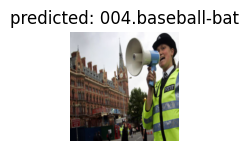

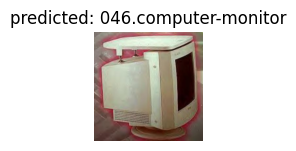

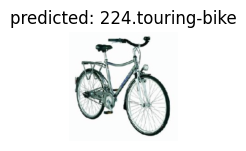

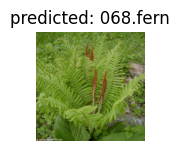

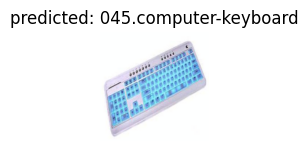

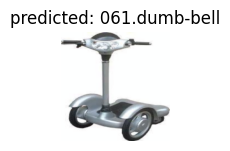

In [18]:
visualize_model(model_ft)

### ONNX

In [19]:
save_to_ONNX(model_ft, "torch-resnet18")

============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [20]:
check_ONNX("torch-resnet18")

Val ONNX acc: 0.628284


Показатели точности моделей в Pytorch и ONNX совпадают

## Реализация ResNet-18

### Класс блока

`ResNet-18` строится из блоков, поэтому их можно описать в отдельном классе

In [21]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=(1 + (in_channels != out_channels)),
            padding=1,
            bias=False,
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(True)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=2, bias=False
                ),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            x = self.downsample(x)
        return self.relu(x + out)

### Класс сети

In [22]:
class my_resnet18(nn.Module):
    def __init__(self, block=BasicBlock, num_classes=1000):
        super(my_resnet18, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = nn.Sequential(block(64, 64), block(64, 64))
        self.layer2 = nn.Sequential(block(64, 128), block(128, 128))
        self.layer3 = nn.Sequential(block(128, 256), block(256, 256))
        self.layer4 = nn.Sequential(block(256, 512), block(512, 512))

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        return self.fc(x.flatten(1))

## Реализованная модель

In [23]:
my_model_ft = my_resnet18(num_classes=len(class_names))

my_model_ft = my_model_ft.to(device)

[SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) лучше всего подходит для обучения `ResNet-18`

In [24]:
my_optimizer_ft = optim.SGD(
    my_model_ft.parameters(),
    lr=MY_LR,
    weight_decay=MY_WEIGHT_DECAY,
    momentum=MY_MOMENTUM,
)

[CosineAnnealingLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html#torch.optim.lr_scheduler.CosineAnnealingLR) изменяет шаг обучения по косинусу

In [25]:
my_cos_lr_scheduler = lr_scheduler.CosineAnnealingLR(my_optimizer_ft, T_max=MY_EPOCHS)

### Обучение модели

In [26]:
my_model_ft = train_model(
    my_model_ft, criterion, my_optimizer_ft, my_cos_lr_scheduler, num_epochs=MY_EPOCHS
)

Epoch 0/79
----------
train Loss: 5.6791 Acc: 0.0049
val Loss: 5.6330 Acc: 0.0038

Epoch 1/79
----------
train Loss: 5.6415 Acc: 0.0070
val Loss: 5.6231 Acc: 0.0188

Epoch 2/79
----------
train Loss: 5.6359 Acc: 0.0095
val Loss: 5.5935 Acc: 0.0235

Epoch 3/79
----------
train Loss: 5.6287 Acc: 0.0118
val Loss: 5.5591 Acc: 0.0121

Epoch 4/79
----------
train Loss: 5.6130 Acc: 0.0109
val Loss: 5.5209 Acc: 0.0218

Epoch 5/79
----------
train Loss: 5.5969 Acc: 0.0123
val Loss: 5.4902 Acc: 0.0171

Epoch 6/79
----------
train Loss: 5.5774 Acc: 0.0150
val Loss: 5.5136 Acc: 0.0345

Epoch 7/79
----------
train Loss: 5.5368 Acc: 0.0202
val Loss: 5.7615 Acc: 0.0368

Epoch 8/79
----------
train Loss: 5.4925 Acc: 0.0249
val Loss: 5.4016 Acc: 0.0529

Epoch 9/79
----------
train Loss: 5.4481 Acc: 0.0330
val Loss: 5.5774 Acc: 0.0648

Epoch 10/79
----------
train Loss: 5.3809 Acc: 0.0428
val Loss: 6.1133 Acc: 0.0636

Epoch 11/79
----------
train Loss: 5.3188 Acc: 0.0519
val Loss: 5.5487 Acc: 0.0923

Ep

### Визуализация результата

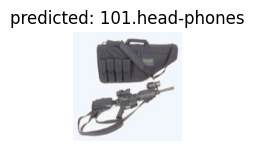

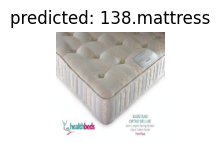

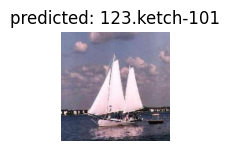

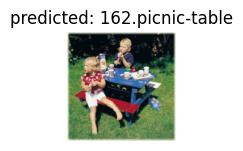

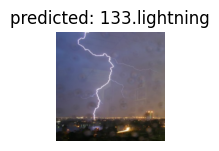

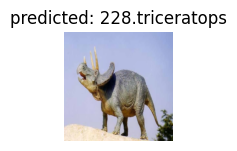

In [27]:
visualize_model(model_ft)

### ONNX

In [28]:
save_to_ONNX(my_model_ft, "my-resnet18")

============= Diagnostic Run torch.onnx.export version 2.0.0+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [29]:
check_ONNX("my-resnet18")

Val ONNX acc: 0.624701


Показатели точности моделей в Pytorch и ONNX совпадают